# **Default Setting**

* Python: 3.6.9
* ML Framework: tf-nightly-gpu 2.5.0-dev20201208
* CPU: AMD Ryzen 5 5600X 6-Core Processor
* GPU: GeForce RTX 3070 (8G) (CUDA 11.1)
* RAM: 32G
* Platform: linux 20.04 LTS

In [1]:
%env NOTEBOOKNAME try10
%env LOCAL_DATA_PATH data
%env SUBMISSION_PATH submission

env: NOTEBOOKNAME=try10
env: LOCAL_DATA_PATH=data
env: SUBMISSION_PATH=submission


In [2]:
import tensorflow as tf
import tensorflow_addons as tfa

import datetime
import glob
import os
import platform
import pydot

import numpy as np
import pandas as pd

from collections import OrderedDict
from math import pi
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

print(f"tf.__version__: {tf.__version__}")
print(f"tfa.__version__: {tfa.__version__}")

/home/myunggyo/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow_addons/utils/ensure_tf_install.py:44: UserWarning: You are currently using a nightly version of TensorFlow (2.5.0-dev20201208). 
TensorFlow Addons offers no support for the nightly versions of TensorFlow. Some things might work, some other might not. 
If you encounter a bug, do not file an issue on GitHub.
  UserWarning,


tf.__version__: 2.5.0-dev20201208
tfa.__version__: 0.11.2


In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
# !python -V

In [5]:
# !cat /proc/cpuinfo

In [4]:
!nvidia-smi

Tue Dec 15 18:15:15 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 455.32.00    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Graphics Device     On   | 00000000:0A:00.0  On |                  N/A |
|  0%   30C    P8    16W / 220W |    376MiB /  7979MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
# !df -h

In [5]:
!free -h

              total        used        free      shared  buff/cache   available
Mem:           31Gi       2.2Gi        26Gi       325Mi       2.2Gi        28Gi
Swap:         2.0Gi          0B       2.0Gi


In [6]:
# platform.platform()

In [7]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

# **Define Arguments**

In [61]:
args = OrderedDict({
    # Basic
    "SEED": 42,
    "TEST_SIZE": 0.2,
    "EPOCH": 10,
    "INIT_LR": 1e-3,
    
    # Dataframe
    "NUM_TEST_CSV": 81,
    
    # Dataset Pipeline
    "WINDOW_INP": 7 * 24 * 2, # 336, 7 days
    "WINDOW_TAR": 2 * 24 * 2, # 96, 2 days
    "WINDOW_SHIFT": 1 * 24 * 2, # 1 day
    "WINDOW_STRIDE": 1,
    "WINDOW_DR": True, # Drop remainders
    "AUTO": tf.data.experimental.AUTOTUNE,
    
    "GLOBAL_BATCH_SIZE": 128,
    
    # Model
    "NUM_UNITS": 64, # lstm units
    "NUM_FEATURES": 7, # Day_sin, Day_cos, DHI, DNI, WS, RH, T
    "NUM_QUANTILE": 9, # tau = 0.1 to 0.9
    
})

args

OrderedDict([('SEED', 42),
             ('TEST_SIZE', 0.2),
             ('EPOCH', 10),
             ('INIT_LR', 0.001),
             ('NUM_TEST_CSV', 81),
             ('WINDOW_INP', 336),
             ('WINDOW_TAR', 96),
             ('WINDOW_SHIFT', 48),
             ('WINDOW_STRIDE', 1),
             ('WINDOW_DR', True),
             ('AUTO', -1),
             ('GLOBAL_BATCH_SIZE', 128),
             ('NUM_UNITS', 64),
             ('NUM_FEATURES', 7),
             ('NUM_QUANTILE', 9)])

# **Load Datasets**

## **Train / Validation**

In [96]:
df = pd.read_csv(os.path.join(os.environ["LOCAL_DATA_PATH"], "train", "train.csv"))

In [97]:
# df.head()

In [98]:
# df.describe()

In [99]:
tr_df, vl_df = train_test_split(
    df, 
    test_size = args["TEST_SIZE"], 
    random_state = args["SEED"])

tr_df.shape, vl_df.shape

((42048, 9), (10512, 9))

In [100]:
def preprocessing(df, is_training = True, day = 24 * 2):
    # Drop timestampes.
    try:
        df = df.drop(["Day"], axis = 1) # cannot use day features
    except:
        pass
    
    
    # Timestamp to sin/cos.
    for column in ["Hour", "Minute"]:
        df[f"_{column}"] = df[column].apply(lambda x: f"{x:0>2d}")
    
    df["Time"] = df[["_Hour", "_Minute"]].apply(lambda x: ":".join(x), axis = 1)
    
    timestamp = pd.to_datetime(df.pop("Time"), format = "%H:%M").map(datetime.datetime.timestamp)
    
    day_sin = tf.math.sin(tf.constant(timestamp.values, dtype = tf.float32) * (2. * pi / day))
    day_cos = tf.math.cos(tf.constant(timestamp.values, dtype = tf.float32) * (2. * pi / day))
    
    df.insert(loc = 0, column = "Day_sin", value = day_sin)
    df.insert(loc = 1, column = "Day_cos", value = day_cos)
    
    df = df.drop(["Hour", "Minute", "_Hour", "_Minute"], axis = 1)
    
    
    # Standarize.
    for column in df.columns:
        if is_training:
            args[f"{column}_MEAN"] = df[column].mean()
            args[f"{column}_STD"] = df[column].std()
        
        df[column] = (df[column] - args[f"{column}_MEAN"]) / args[f"{column}_STD"]
        
    return df

In [101]:
tr_df = preprocessing(tr_df)
vl_df = preprocessing(vl_df, is_training = False)

In [102]:
tr_df

,Day_sin,Day_cos,DHI,DNI,WS,RH,T,TARGET
36155,1.065658,-0.948410,-0.619163,-0.670927,-0.950662,0.712244,-1.400211,-0.690053
42664,1.289056,0.674420,-0.619163,-0.670927,-0.459068,0.013638,0.761006,-0.690053
35439,0.611017,1.284300,-0.619163,-0.670927,3.614135,1.019866,-0.516077,-0.690053
1647,0.611017,1.284300,-0.561089,-0.670927,1.647761,1.412661,-1.203737,-0.668124
6206,0.747367,-1.192170,0.958516,-0.459386,-0.037703,0.746222,-0.909025,0.011654
...,...,...,...,...,...,...,...,...
11284,-0.308149,-1.343083,-0.619163,-0.670927,-0.459068,-0.332493,0.269820,-0.690053
44732,-0.332989,1.361497,-0.619163,-0.670927,-0.880434,1.790506,0.761006,-0.690053
38158,1.458077,-0.086894,-0.619163,-0.670927,1.156167,-0.581672,-1.596686,-0.690053
860,-0.332989,1.361497,-0.619163,-0.670927,0.594346,0.693215,-0.909025,-0.690053


In [103]:
tr_df.describe()

,Day_sin,Day_cos,DHI,DNI,WS,RH,T,TARGET
count,4.204800e+04,4.204800e+04,4.204800e+04,4.204800e+04,4.204800e+04,4.204800e+04,4.204800e+04,4.204800e+04
mean,5.987681e-09,-9.435134e-09,-1.064597e-17,-1.199784e-17,1.203164e-16,2.484061e-16,-5.660955e-17,-1.422843e-16
std,9.999999e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.411554e+00,-1.379975e+00,-6.191629e-01,-6.709268e-01,-1.723166e+00,-2.229873e+00,-2.775532e+00,-6.900532e-01
25%,-8.950300e-01,-9.579576e-01,-6.191629e-01,-6.709268e-01,-7.399790e-01,-7.769368e-01,-8.107883e-01,-6.900532e-01
50%,-1.591435e-01,3.684847e-02,-6.191629e-01,-6.709268e-01,-1.781579e-01,3.674375e-02,-2.489105e-02,-6.900532e-01
75%,1.065658e+00,9.906173e-01,2.229109e-01,6.726452e-01,5.241185e-01,7.271943e-01,7.610062e-01,5.560395e-01
max,1.461490e+00,1.404771e+00,4.491354e+00,2.356398e+00,6.704151e+00,1.956776e+00,2.529275e+00,3.194405e+00


In [104]:
vl_df.describe()

,Day_sin,Day_cos,DHI,DNI,WS,RH,T,TARGET
count,10512.000000,10512.000000,10512.000000,10512.000000,10512.000000,10512.000000,10512.000000,10512.000000
mean,-0.018077,-0.000770,0.018122,0.001328,0.008241,-0.003595,0.013041,0.013841
std,0.994606,1.004529,1.027720,0.998199,1.010278,0.995579,1.000124,1.015730
min,-1.411554,-1.379975,-0.619163,-0.670927,-1.652938,-2.211298,-2.579057,-0.690053
25%,-0.914538,-1.057862,-0.619163,-0.670927,-0.739979,-0.771953,-0.810788,-0.690053
50%,-0.184493,-0.000889,-0.619163,-0.670927,-0.178158,0.033572,-0.024891,-0.690053
75%,1.047850,1.066183,0.242269,0.655493,0.524119,0.701823,0.761006,0.570552
max,1.461490,1.404771,4.442959,2.350681,6.563695,1.956776,2.529275,3.200901


## **Test**

In [18]:
ts_filenames = [os.path.join(os.environ["LOCAL_DATA_PATH"], "test", f"{i}.csv") for i in range(args["NUM_TEST_CSV"])]
ts_dfs = [preprocessing(pd.read_csv(ts_filename), is_training = False) for ts_filename in ts_filenames]
ts_df = pd.concat(ts_dfs)

In [19]:
ts_df.head()

,Day_sin,Day_cos,DHI,DNI,WS,RH,T,TARGET
0,-1.411554,-0.000889,-0.619163,-0.670927,0.172980,-1.014336,-0.909025,-0.690053
1,0.095690,-1.379386,-0.619163,-0.670927,0.172980,-1.025662,-0.899202,-0.690053
2,1.456030,0.136017,-0.619163,-0.670927,0.172980,-1.022944,-0.889378,-0.690053
3,-0.914538,1.066183,-0.619163,-0.670927,0.172980,-1.033817,-0.879554,-0.690053
4,-0.308149,-1.343083,-0.619163,-0.670927,0.243208,-1.034723,-0.869731,-0.690053


In [20]:
ts_df.describe()

,Day_sin,Day_cos,DHI,DNI,WS,RH,T,TARGET
count,27216.000000,27216.000000,27216.000000,27216.000000,27216.000000,27216.000000,27216.000000,27216.000000
mean,-0.003615,-0.000154,-0.047397,0.046952,-0.127593,-0.471834,0.048424,0.020077
std,0.998949,1.000907,0.886646,1.023778,0.893017,0.868807,1.108719,1.017022
min,-1.411554,-1.379975,-0.619163,-0.670927,-1.652938,-2.351291,-2.451349,-0.690053
25%,-0.899907,-0.982934,-0.619163,-0.670927,-0.810207,-1.165768,-0.869731,-0.690053
50%,-0.171818,0.017980,-0.561089,-0.670927,-0.318613,-0.452099,-0.054362,-0.668126
75%,1.052302,1.009509,0.184195,0.775557,0.313436,0.184439,0.888715,0.577827
max,1.461490,1.404771,4.288095,2.413571,6.001874,1.620159,2.696278,3.182867


# **Phase \#1: Target Predict Model**

## **Make Dataset Pipelines**

In [21]:
@tf.function
def _split_window(features):
    return tf.split(features, [-1, 1], axis = 0)

In [22]:
tr_tensor = tf.constant(tr_df, dtype = tf.float32)
vl_tensor = tf.constant(vl_df, dtype = tf.float32)
ts_tensor = tf.constant(ts_df, dtype = tf.float32)

tr_dataset = tf.data.Dataset.from_tensor_slices(tr_tensor
                    ).map(_split_window, num_parallel_calls = args["AUTO"]
                    ).batch(args["GLOBAL_BATCH_SIZE"]
                    ).cache(
                    ).prefetch(args["AUTO"])

vl_dataset = tf.data.Dataset.from_tensor_slices(vl_tensor
                    ).map(_split_window, num_parallel_calls = args["AUTO"]
                    ).batch(args["GLOBAL_BATCH_SIZE"]
                    ).cache(
                    ).prefetch(args["AUTO"])

ts_dataset = tf.data.Dataset.from_tensor_slices(ts_tensor
                    ).map(_split_window, num_parallel_calls = args["AUTO"]
                    ).batch(args["GLOBAL_BATCH_SIZE"]
#                     ).cache(
                    ).prefetch(args["AUTO"])

# Print the shapes
print(f"tr_dataset: {tr_dataset.element_spec}")
print(f"vl_dataset: {vl_dataset.element_spec}")
print(f"ts_dataset: {ts_dataset.element_spec}")

tr_dataset: (TensorSpec(shape=(None, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))
vl_dataset: (TensorSpec(shape=(None, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))
ts_dataset: (TensorSpec(shape=(None, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))


### **Take Samples**

In [23]:
for element in tr_dataset.take(1):
    foo, bar = element
    print(foo.shape, bar.shape)

(128, 7) (128, 1)


In [24]:
for element in vl_dataset.take(1):
    foo, bar = element
    print(foo.shape, bar.shape)

(128, 7) (128, 1)


In [25]:
for element in ts_dataset.take(1):
    foo, bar = element
    print(foo.shape, bar.shape)

(128, 7) (128, 1)


## **Create Network**

```
"""Pytorch Style"""
class TARGET_MODEL(tf.keras.Model):
    def __init__(self, units, name):
        super(TARGET_MODEL, self).__init__(name = name)
        self.units = units
        
        self.dense1 = tf.keras.layers.Dense(units = self.units, activation = "relu")
        self.dense2 = tf.keras.layers.Dense(units = self.units, activation = "relu")
        self.dense3 = tf.keras.layers.Dense(units = 1)
        
    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.dense3(x)
        
        return x            
```

In [26]:
def TARGET_MODEL(model_name, units = 64):
    model_input = tf.keras.layers.Input(shape = [7, ], dtype = tf.float32)
    
    x = tf.keras.layers.Dense(units = units, activation = "relu")(model_input)
    x = tf.keras.layers.Dense(units = units, activation = "relu")(x)    
    model_output = tf.keras.layers.Dense(1)(x)
    
    return tf.keras.Model(
        inputs = model_input,
        outputs = model_output,
        name = model_name)

In [27]:
tmp = TARGET_MODEL("tmp")
tmp.summary()

Model: "tmp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 7)]               0         
_________________________________________________________________
dense (Dense)                (None, 64)                512       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [166]:
# tf.keras.utils.plot_model(tmp)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [28]:
del tmp

## **Compile and Fit**

In [29]:
target_model = TARGET_MODEL(
    model_name = "target_model",
    units = 64)

target_model.compile(
    loss = tf.keras.losses.MAE,
    optimizer = tf.keras.optimizers.Adam())

In [30]:
# TensorBoard callback.
log_dir = os.path.join(
    "logs", "fit", os.environ["NOTEBOOKNAME"], 
    datetime.datetime.now().strftime(f"{target_model.name}-%Y%m%d-%H%M%S"))
tb_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir, histogram_freq = 1)

history = target_model.fit(
    tr_dataset,
    validation_data = vl_dataset,
    epochs = 500,
    verbose = 0,
    callbacks = [tb_callback])

In [33]:
def draw_history(history, ylim: list):
    
    plt.figure(figsize = (7, 5), facecolor = "white", dpi = 80)
    
    plt.plot(history.epoch, history.history["loss"], color = "tomato", label = "loss", alpha = .8)
    plt.plot(history.epoch, history.history["val_loss"], color = "navy", label = "val_loss", alpha = .8)
    
    plt.ylim(ylim)
    plt.xlabel("epoch")
    plt.ylabel("loss (MAE)")
    
    plt.grid(True)
    plt.tight_layout()
    plt.show()

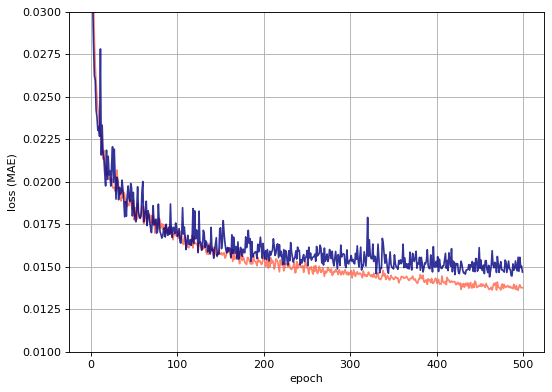

In [34]:
draw_history(history, ylim = [0.01, 0.03])

In [36]:
# %tensorboard --logdir logs/fit --host jupyter-server

## **Predict**

In [37]:
target_model.evaluate(ts_dataset, verbose = 1)

213/213 [==============================] - 0s 773us/step - loss: 0.0267


0.026667241007089615

# **Phase \#2: AT Model**

## **Make Dataset Pipelines**

In [38]:
@tf.function
def _flat_fn_tr(x):
    return x.batch(args["WINDOW_INP"] + args["WINDOW_TAR"])


@tf.function
def _flat_fn_ts(x):
    return x.batch(args["WINDOW_INP"])


@tf.function
def _split_window_tr(features):
    inp, tar = tf.split(features, [args["WINDOW_INP"], args["WINDOW_TAR"]], axis = 0)
    return inp[..., :-1], tar[..., -1:] # inp: (batch, 336, 7), tar: (batch, 96, 1)


@tf.function
def _split_window_ts(features):
    return features[..., :-1] # (batch, 336, 7)

In [39]:
tr_tensor = tf.constant(tr_df, dtype = tf.float32)
vl_tensor = tf.constant(vl_df, dtype = tf.float32)
ts_tensor = tf.constant(ts_df, dtype = tf.float32)

tr_dataset = tf.data.Dataset.from_tensor_slices(tr_tensor
                    ).window(args["WINDOW_INP"] + args["WINDOW_TAR"], args["WINDOW_SHIFT"], args["WINDOW_STRIDE"], args["WINDOW_DR"]).flat_map(_flat_fn_tr
                    ).map(_split_window_tr, num_parallel_calls = args["AUTO"]
                    ).batch(args["GLOBAL_BATCH_SIZE"]
                    ).cache(
                    ).prefetch(args["AUTO"])

vl_dataset = tf.data.Dataset.from_tensor_slices(vl_tensor
                    ).window(args["WINDOW_INP"] + args["WINDOW_TAR"], args["WINDOW_SHIFT"], args["WINDOW_STRIDE"], args["WINDOW_DR"]).flat_map(_flat_fn_tr
                    ).map(_split_window_tr, num_parallel_calls = args["AUTO"]
                    ).batch(args["GLOBAL_BATCH_SIZE"]
                    ).cache(
                    ).prefetch(args["AUTO"])

ts_dataset = tf.data.Dataset.from_tensor_slices(ts_tensor
                    ).window(args["WINDOW_INP"], args["WINDOW_INP"], args["WINDOW_STRIDE"], args["WINDOW_DR"]).flat_map(_flat_fn_ts
                    ).map(_split_window_ts, num_parallel_calls = args["AUTO"]
                    ).batch(args["NUM_TEST_CSV"] # Not args["GLOBAL_BATCH_SIZE"]
#                     ).cache(
                    ).prefetch(args["AUTO"])

# Print the shapes
print(f"tr_dataset: {tr_dataset.element_spec}")
print(f"vl_dataset: {vl_dataset.element_spec}")
print(f"ts_dataset: {ts_dataset.element_spec}")

tr_dataset: (TensorSpec(shape=(None, 336, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 96, 1), dtype=tf.float32, name=None))
vl_dataset: (TensorSpec(shape=(None, 336, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 96, 1), dtype=tf.float32, name=None))
ts_dataset: TensorSpec(shape=(None, None, 7), dtype=tf.float32, name=None)


### **Take Samples**

In [40]:
for element in tr_dataset.take(1):
    foo, bar = element
    print(foo.shape, bar.shape)

(128, 336, 7) (128, 96, 1)


In [41]:
for element in vl_dataset.take(1):
    foo, bar = element
    print(foo.shape, bar.shape)

(128, 336, 7) (128, 96, 1)


In [42]:
for element in ts_dataset.take(1):
    foo = element
    print(foo.shape)

(81, 336, 7)


## **Create Network**

In [84]:
class AR_LSTM(tf.keras.Model):
    def __init__(self, target_model, units, out_steps, name):
        super(AR_LSTM, self).__init__(name = name)
        self.target_model = target_model # [batch, 7] -> [batch, 1]
        self.units = units
        self.out_steps = out_steps
        self.num_features = args["NUM_FEATURES"]
        
#         self.lstm = tf.keras.layers.LSTM(self.num_features, return_state = True)
        
#         self.lstm1 = tf.keras.layers.LSTM(self.units, return_sequences = True)
#         self.lstm2 = tf.keras.layers.LSTM(self.num_features, return_sequences = False, return_state = True)
        
        self.lstm_cell = tf.keras.layers.LSTMCell(self.units)
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state = True)
        self.dense = tf.keras.layers.Dense(self.num_features)
        
    
    def warmup(self, inputs):
        # [batch, time, features] => [batch, units]
        x, *state = self.lstm_rnn(inputs)
        # [batch, units] => [batch, num_features]
        prediction = self.dense(x)
        return prediction, state
        
        
    def call(self, inputs, training = None):
        predictions = []
        
        prediction, state = self.warmup(inputs)
        predictions.append(self.target_model(prediction))
        
        for n in range(1, self.out_steps):
            x = prediction
            # [batch, num_features] => [batch, units]
            x, state = self.lstm_cell(x, states = state, training = training)
            # [batch, units] => [batch, num_features]
            prediction = self.dense(x)
            predictions.append(self.target_model(prediction))
            
        predictions = tf.stack(predictions, axis = 1)
        return predictions

## **Compile and Fit**

In [85]:
target_model.trainable = False # fix the weights
models = []

for tau in np.arange(0.1, 1, 0.1):   
    model = AR_LSTM(
        target_model = target_model,
        units = args["NUM_UNITS"],
        out_steps = args["WINDOW_TAR"],
        name = f"P{tau:.1f}")

    model.compile(
        loss = tfa.losses.PinballLoss(tau = tau),
        optimizer = tf.keras.optimizers.Adam(args["INIT_LR"]))
    
    models.append(model)

In [86]:
for model in models:
    # TensorBoard callback.
    log_dir = os.path.join(
        "logs", "fit", os.environ["NOTEBOOKNAME"], 
        datetime.datetime.now().strftime(f"{model.name}-%Y%m%d-%H%M%S"))
    tb_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir, histogram_freq = 1)

    print(f"\nModel {model.name}...\n")
    
    _ = model.fit(
        tr_dataset,
        validation_data = vl_dataset,
        epochs = args["EPOCH"],
        verbose = 2,
        callbacks = [tb_callback])


Model P0.1...

Epoch 1/10
7/7 - 15s - loss: 0.1976 - val_loss: 0.1120
Epoch 2/10
7/7 - 1s - loss: 0.1098 - val_loss: 0.1014
Epoch 3/10
7/7 - 1s - loss: 0.0873 - val_loss: 0.0821
Epoch 4/10
7/7 - 1s - loss: 0.0781 - val_loss: 0.0776
Epoch 5/10
7/7 - 1s - loss: 0.0743 - val_loss: 0.0740
Epoch 6/10
7/7 - 1s - loss: 0.0727 - val_loss: 0.0745
Epoch 7/10
7/7 - 1s - loss: 0.0719 - val_loss: 0.0718
Epoch 8/10
7/7 - 1s - loss: 0.0712 - val_loss: 0.0725
Epoch 9/10
7/7 - 1s - loss: 0.0708 - val_loss: 0.0723
Epoch 10/10
7/7 - 1s - loss: 0.0708 - val_loss: 0.0725

Model P0.2...

Epoch 1/10
7/7 - 15s - loss: 0.2485 - val_loss: 0.2364
Epoch 2/10
7/7 - 2s - loss: 0.2028 - val_loss: 0.1763
Epoch 3/10
7/7 - 1s - loss: 0.1591 - val_loss: 0.1523
Epoch 4/10
7/7 - 1s - loss: 0.1478 - val_loss: 0.1456
Epoch 5/10
7/7 - 1s - loss: 0.1442 - val_loss: 0.1489
Epoch 6/10
7/7 - 1s - loss: 0.1445 - val_loss: 0.1423
Epoch 7/10
7/7 - 1s - loss: 0.1431 - val_loss: 0.1454
Epoch 8/10
7/7 - 1s - loss: 0.1424 - val_loss: 

In [87]:
%tensorboard --logdir logs/fit --host jupyter-server

Reusing TensorBoard on port 6006 (pid 7385), started 1:12:09 ago. (Use '!kill 7385' to kill it.)

## **Predict**

In [89]:
preds = [np.array(model.predict(ts_dataset))[..., 0] for model in models]
preds[0].shape

(81, 96)

In [90]:
submission = pd.read_csv(os.path.join(os.environ["LOCAL_DATA_PATH"], "sample_submission.csv"), index_col = "id")
submission.head()

,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
id,,,,,,,,,
0.csv_Day7_0h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.csv_Day7_0h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.csv_Day7_1h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.csv_Day7_1h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.csv_Day7_2h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [110]:
for column, pred in zip(submission.columns, preds):
    foo = np.reshape(pred, (-1,))
    foo = (foo * args["TARGET_STD"]) + args["TARGET_STD"]
#     foo = np.where(foo < 0, 0, foo) # clip by value
    
    submission[column] = foo

In [111]:
submission.head()

,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
id,,,,,,,,,
0.csv_Day7_0h00m,11.330930,8.789949,12.106797,8.433870,15.178031,21.560562,20.705690,65.827957,71.649048
0.csv_Day7_0h30m,10.612611,9.429886,10.970112,7.928766,14.490046,21.027855,22.297714,66.879959,74.571609
0.csv_Day7_1h00m,9.664053,9.300856,9.747580,7.563658,14.186021,19.640682,23.819099,65.307465,72.750687
0.csv_Day7_1h30m,8.872568,9.012264,8.915426,7.355059,13.844507,17.942604,24.752573,63.269016,71.262589
0.csv_Day7_2h00m,8.248011,8.722410,8.382359,7.250301,13.504272,16.236866,25.461878,61.158997,70.442886


In [112]:
submission.to_csv(
    os.path.join(os.environ["SUBMISSION_PATH"], f"{os.environ['NOTEBOOKNAME']}_submission.csv"))